In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib as pt
import random
import tensorflow as tf
import yaml

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model

from UNetModel import UNetModel

In [20]:
config = None
with open('config.yaml') as f: # reads .yml/.yaml files
    config = yaml.safe_load(f)

## Creare dataset

In [21]:
def create_dataset_csv(images_dir, right_masks_dir, left_masks_dir, csv_path):
    """Generare csv cu caile catre imaginile de input si mastile de segmentare

    Args:
        images_dir (str or pathlib.Path): calea catre directorul cu imagini de input
        right_masks_dir (str or pathlib.Path): calea catre directorul cu masti de segmentare pt plamanul drept
        left_masks_dir (str or pathlib.Path): calea catre directorul cu masti de segmentare pt plamanul stang
        csv_path (str or pathlib.Path): calea si numele fisierul csv care va fi salvat

    Returns:
        pandas.DataFrame: contine caile catre fiecare imagine de input sau masca de segmentare
    """

    # se citesc toate caile catre imagini si masti de segmentare
    # este important sa fie in aceeasi ordine
    images = sorted(list(pt.Path(images_dir).rglob("*.png")))
    right_masks = sorted(list(pt.Path(right_masks_dir).rglob("*.png")))
    left_masks = sorted(list(pt.Path(left_masks_dir).rglob("*.png")))

    # se verifica daca nu exista masti lipsa pentru unul dintre plamani
    assert len(right_masks) == len(left_masks), \
         f"nr. of right lung masks {len(right_masks)} != {len(left_masks)} nr. of left lung masks"
    
    # se verifica daca nu exista imagini sau masti lipsa
    assert len(images) == len(left_masks), \
         f"nr. of image{len(images)} != {len(left_masks)} nr. of masks"

    # se creaza un dictionar de liste, pe baza caruia se creaza obiectul de tip pandas.DataFrame
    dataset_data = {"image_path": images, "right_lung_mask_path": right_masks, "left_lung_mask_path": left_masks}

    dataset_df = pd.DataFrame(data=dataset_data)
    dataset_df.to_csv(csv_path, index=False)
    print(f"Saved dataset csv {csv_path}")

    return dataset_df

def split_dataset(dataset_df, split_per, seed=1):
    """Impartirea setului de date in antrenare, validare si testare in mod aleatoriu

    Args:
        dataset_df (pandas.DataFrame): contine caile catre imaginile de input si mastile de segmentare
        split_per (dict): un dictionare de forma {"train": float, "valid": float, "test": float} ce descrie
            procentajele pentru fiecare subset
        seed (int, optional): valoarea seed pentru reproducerea impartirii setului de date. Defaults to 1.
    """
    # se amesteca aleatoriu indecsii DataFrame-ului
    # indexul este un numar (de cele mai multe ori) asociat fiecarui rand
    indices = dataset_df.index.to_numpy() 
    total = len(indices)
    random.seed(seed)
    random.shuffle(indices)

    # se impart indecsii in functie de procentele primite ca input
    train_idx = int(total * split_per["train"])
    valid_idx = train_idx + int(total * split_per["valid"])
    test_idx = train_idx + valid_idx + int(total * split_per["test"])

    train_indices = indices[:train_idx]
    valid_indices = indices[train_idx:valid_idx]
    test_indices = indices[valid_idx:test_idx]

#     print(len(train_indices), len(valid_indices), len(test_indices))

    # se adauga o noua coloana la DataFrame care specifica in ce subset face parte o imagine si mastile de segmentare asociate
    dataset_df['subset'] = ""
    dataset_df.loc[train_indices, "subset"] = "train"
    dataset_df.loc[valid_indices, "subset"] = "valid"
    dataset_df.loc[test_indices, "subset"] = "test"

    return dataset_df

In [22]:
dataset_df = create_dataset_csv(config["data"]["images_dir"], 
                                config["data"]["right_masks_dir"],
                                config["data"]["left_masks_dir"],
                                config["data"]["data_csv"])

Saved dataset csv dataset_seg.csv


In [23]:
dataset_df = split_dataset(dataset_df, split_per=config['data']['split_per'], seed=1)
dataset_df.head(3)

,image_path,right_lung_mask_path,left_lung_mask_path,subset
0,D:\work\03_intership\AI intro\7. Retele Comple...,D:\work\03_intership\AI intro\7. Retele Comple...,D:\work\03_intership\AI intro\7. Retele Comple...,valid
1,D:\work\03_intership\AI intro\7. Retele Comple...,D:\work\03_intership\AI intro\7. Retele Comple...,D:\work\03_intership\AI intro\7. Retele Comple...,train
2,D:\work\03_intership\AI intro\7. Retele Comple...,D:\work\03_intership\AI intro\7. Retele Comple...,D:\work\03_intership\AI intro\7. Retele Comple...,train


In [24]:
class LungSegDataGenerator(keras.utils.Sequence):
    """Un DataGenerator custom pentru setul de date pentru segmentare plamanilor"""

    def __init__(self, dataset_df, img_size, batch_size, shuffle=True):
        self.dataset_df = dataset_df.reset_index(drop=True)
        self.img_size = tuple(img_size)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset_df))

    def __len__(self):
        """
        Returns:
            int: Returneaza numarul de batches per epoca
        """
        return len(self.indexes) // self.batch_size

    def __combine_masks(self, img_right, img_left):
        """Combina mastile pentru cei doi plamani intr-o singura masca

        Args:
            img_right (pillow.Image): masca pentru plamanul drept
            img_left (pillow.Image): masca pentru plamanul stang

        Returns:
            numpy.array: masca cu cei doi plamani
        """

        img_right = np.array(img_right, dtype="uint8") * 1/255
        img_left = np.array(img_left, dtype="uint8") * 1/255

        img = (img_right + img_left).astype("uint8")

        return img


    def __getitem__(self, idx):
        """Returneaza un tuple (input, target) care corespunde cu batch #idx.

        Args:
            idx (int): indexul batch-ului curent

        Returns:
           tuple:  (input, target) care corespunde cu batch #idx
        """

        i = idx * self.batch_size
        batch_indexes = self.indexes[i:i+self.batch_size]
        batch_df = self.dataset_df.loc[batch_indexes, :].reset_index(drop=True)

        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")

        for i, row in batch_df.iterrows():
            img = load_img(row['image_path'], target_size=self.img_size, color_mode="grayscale")
            x[i] = np.expand_dims(img, axis=2)

            img_right = load_img(row['right_lung_mask_path'], target_size=self.img_size, color_mode="grayscale")
            img_left = load_img(row['left_lung_mask_path'], target_size=self.img_size, color_mode="grayscale")

            img = self.__combine_masks(img_right, img_left)

            y[i] = np.expand_dims(img, axis=2)
        
        return x, y
    
    def on_epoch_end(self):
        """
        Actualizeaza indecsii dupa fiecare epoca si ii amesteca daca parametrul shuffle este True 
        """
        self.indexes = np.arange(len(self.dataset_df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

### Vizualizare exemple date folosind DataGenerator custom

In [25]:
data_gen = LungSegDataGenerator(dataset_df, img_size=config["data"]["img_size"], batch_size=config["train"]["bs"])
x, y = data_gen[0]
print(x.shape, y.shape)


(8, 128, 128, 1) (8, 128, 128, 1)


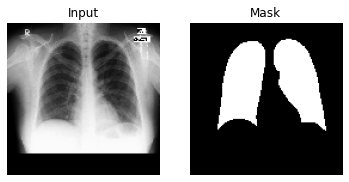

In [26]:
f, axs = plt.subplots(1, 2)
axs[0].axis('off')
axs[0].set_title("Input")
axs[0].imshow(x[0], cmap="gray")

axs[1].axis('off')
axs[1].set_title("Mask")
axs[1].imshow(y[0], cmap="gray")

## Creare model de tip U-Net

In [27]:
unet = UNetModel()
unet_model = unet.build(*config["data"]["img_size"], n_channels=1, n_classes=1)
unet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 128, 128, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_14 (Batc (None, 128, 128, 32) 128         conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 32) 9248        batch_normalization_v1_14[0][0]  
__________________________________________________________________________________________________
batch_norm

Se creaza generatoarele pentru antrenare si validare pornind de la DataFrame-ul creat anterior. Se filtreaza dupa coloana `subset`.

In [28]:
train_df = dataset_df.loc[dataset_df["subset"] == "train", :]
train_gen = LungSegDataGenerator(train_df, img_size=config["data"]["img_size"], batch_size=config["train"]["bs"], shuffle=True)

valid_df = dataset_df.loc[dataset_df["subset"] == "valid", :]
valid_gen = LungSegDataGenerator(valid_df, img_size=config["data"]["img_size"], batch_size=config["train"]["bs"], shuffle=True)

## Antrenare model de segmentare

In [29]:
unet_model.compile(optimizer=config["train"]["opt"], loss="binary_crossentropy", metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("lung_seg.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
history = unet_model.fit(train_gen, epochs=config["train"]["epochs"], validation_data=valid_gen, callbacks=callbacks)

Epoch 1/10
13/13 [==============================] - 45s 3s/step - loss: 3.1368 - acc: 0.8486 - val_loss: 30.6005 - val_acc: 0.7611
Epoch 2/10
13/13 [==============================] - 36s 3s/step - loss: 1.2974 - acc: 0.9647 - val_loss: 30.2059 - val_acc: 0.7634
Epoch 3/10
13/13 [==============================] - 38s 3s/step - loss: 0.9008 - acc: 0.9747 - val_loss: 23.3488 - val_acc: 0.7497
Epoch 4/10
13/13 [==============================] - 38s 3s/step - loss: 0.6458 - acc: 0.9801 - val_loss: 9.5120 - val_acc: 0.7614
Epoch 5/10
13/13 [==============================] - 39s 3s/step - loss: 0.5389 - acc: 0.9820 - val_loss: 5.9853 - val_acc: 0.7746
Epoch 6/10
13/13 [==============================] - 40s 3s/step - loss: 0.4828 - acc: 0.9837 - val_loss: 5.6949 - val_acc: 0.7643
Epoch 7/10
13/13 [==============================] - 38s 3s/step - loss: 0.4335 - acc: 0.9844 - val_loss: 4.5213 - val_acc: 0.8100
Epoch 8/10
13/13 [==============================] - 38s 3s/step - loss: 0.3847 - acc: 0

## Afisare curbe de invatare

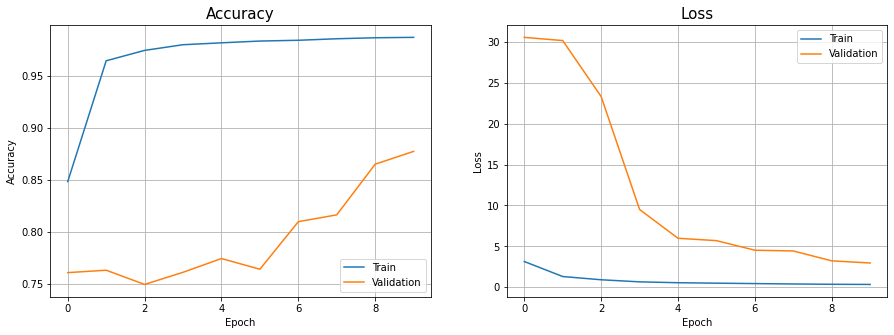

In [30]:
def plot_acc_loss(result):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.title('Accuracy', size=15)
    plt.legend()
    plt.grid(True)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.subplot(122)
    plt.plot(loss, label='Train')
    plt.plot(val_loss, label='Validation')
    plt.title('Loss', size=15)
    plt.legend()
    plt.grid(True)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.show()
    
plot_acc_loss(history)

## Testarea modelului antrenat

In acelasi mod ca si la antrenare se creaza un generator pentru subsetul cu imagini de testare. De data asta `shuffle=False`

In [31]:
test_df = dataset_df.loc[dataset_df["subset"] == "test", :]
test_gen = LungSegDataGenerator(test_df, img_size=config["data"]["img_size"], batch_size=config["train"]["bs"], shuffle=False)
result = unet_model.evaluate(test_gen)
print(f"Test Acc: {result[1] * 100}")

1/1 [==============================] - 2s 2s/step - loss: 2.4265 - acc: 0.8950
Test Acc: 89.49966430664062


### Vizualizare predictii

In [35]:
x, y = test_gen[0]
y_pred = unet_model.predict(x)
y_pred.shape

(8, 128, 128, 1)

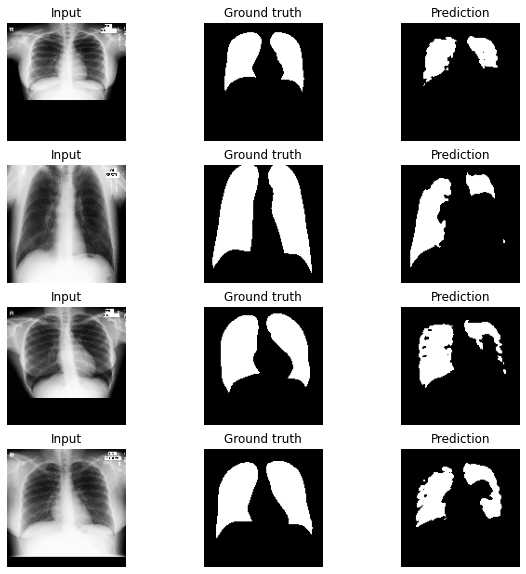

In [36]:
nr_exs = 4 # nr de exemple de afisat
fig, axs = plt.subplots(nr_exs, 3, figsize=(10, 10))
for i, (img, gt, pred) in enumerate(zip(x[:nr_exs], y[:nr_exs], y_pred[:nr_exs])):
    axs[i][0].axis('off')
    axs[i][0].set_title('Input')
    axs[i][0].imshow(img, cmap='gray')

    axs[i][1].axis('off')
    axs[i][1].set_title('Ground truth')
    axs[i][1].imshow(gt, cmap='gray')

    pred[pred > config['test']['threshold']] = 1
    pred[pred <= config['test']['threshold']] = 0
    pred = pred.astype("uint8")

    axs[i][2].axis('off')
    axs[i][2].set_title('Prediction')
    axs[i][2].imshow(pred, cmap='gray')